In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Computation of the Marginal Function in the Normal Case

We want to compute
$$
\mathbb{E}[\mathbb{E}[\Delta | \hat{\Delta}]^+] - \mathbb{E}[\hat\Delta_i]^+
$$
As a function of the number of users inputted $n_i.$ Recall that $\Delta$,$\hat{\Delta}$ come from the Empirical Bayes model $\Delta_i \sim G$ and 
$$
\hat{\Delta}_i \sim \mathsf{N}\left(\Delta_i,\frac{\sigma^2}{n_i}\right).
$$




## Base A/B Testing Problem

In [3]:
params = {
"program1": (-0.01, 0.05),
"program2": (-0.005, 0.05),
"program3": (-0.05, 0.1),
}


names = {
  "program1": "Program 1",
"program2": "Program 2",
"program3": "Program 3"  
}

sigmas = {
  "program1": 4.,
  "program2": 4.,
  "program3":  6. 
}

program_sizes = {
  "program1": 80,
  "program2": 40,
  "program3":  10 
}

programs = ["program1", 
            "program2",
            "program3"]


program = "program1"
mu = params[program][0]
tau = params[program][1] 
sigma = sigmas[program]

mu_p = max(mu,0)

def mvar(n):
  return tau**2 + sigma**2/n

def production_function(n):
  return tau**2/(np.sqrt(2*np.pi*mvar(n))) * np.exp(-mu**2 * mvar(n)/(2* tau**4)) + mu*norm.cdf(mu*np.sqrt(mvar(n))/tau**2) - mu_p

## Optimizing the Production Function

Recall that the optimal solution is (approximately)
$$
\max_{i=1,\dots,I} if(N/i)
$$
with the optimal $i$ telling you how many tests to run at a given moment.

440.4075931052156


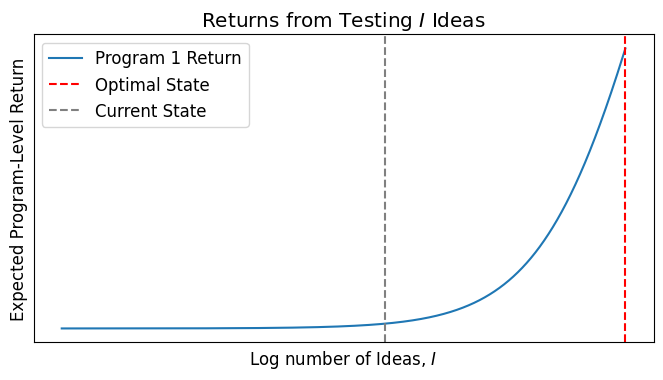

In [5]:
plt.rcParams['font.size'] = 12
I = 50_000
N = 250e6
x = np.arange(1,I)
plt.figure(figsize = (8,4))
#plt.plot(x,x*production_function(N/x), label = names[program])
plt.plot(np.log(x),x*production_function(N/x), label = "Program 1 Return")
plt.title("Returns from Testing $I$ Ideas")
plt.xlabel("Log number of Ideas, $I$")
plt.ylabel("Expected Program-Level Return")
plt.yticks([])
plt.xticks([])
#plt.xticks(labels = ["0","10,000","20,000","30,000","40,000","50,000"])

print(I*production_function(N/I))
opt = np.argmax(x*production_function(N/x))
plt.axvline(np.log(opt), color = 'red', linestyle = 'dashed', label = 'Optimal State')
plt.axvline(np.log(500), color = 'gray', linestyle = 'dashed', label = 'Current State')
plt.legend()

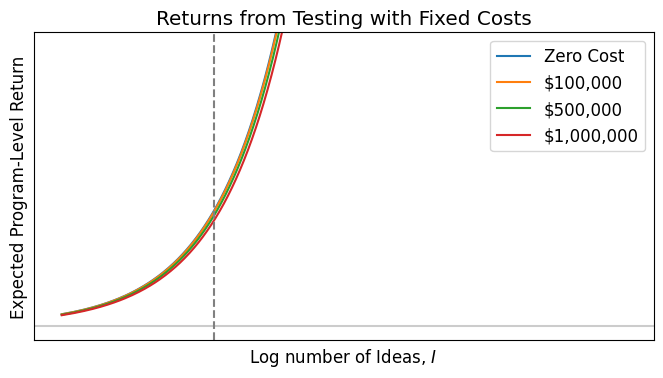

In [7]:
plt.rcParams['font.size'] = 12
I = 50_000
N = 250e6


mu = -0.00055
c0 = 100000/6e8 # converts from dollars to QPD. In terms of mu?
#c = 0.5*np.abs(mu)

x = np.arange(10,I)
plt.figure(figsize = (8,4))
#plt.plot(x,x*production_function(N/x), label = names[program])

labels = ["Zero Cost", "$100,000","$500,000","$1,000,000"]
costs = [0,c0,5*c0,10*c0]

for i,c in enumerate(costs):
    a = x*production_function(N/x) - c*x
    line, = plt.plot(np.log10(x),a, label = labels[i])
    opt_cost = x[np.argmax(a)]
    plt.scatter(np.log10(opt_cost), opt_cost*(production_function(N/opt_cost) - c), color = line.get_color(), linestyle = 'dashed')
plt.title("Returns from Testing with Fixed Costs")
plt.xlabel("Log number of Ideas, $I$")
plt.ylabel("Expected Program-Level Return")
plt.yticks([])
plt.xticks([])
#plt.xticks(labels = ["0","10,000","20,000","30,000","40,000","50,000"])

plt.ylim([-0.25,5])

#print(I*production_function(N/I))
plt.axhline(0, color = 'black', alpha = 0.2)
plt.axvline(np.log10(100), color = 'gray', linestyle = 'dashed')
plt.legend()

In [6]:
def optimal_production(N,I):
    #approximate value
    x = np.arange(1,I+1)
    return max(x*production_function(N/x))

As expected, the solution is lean experimentation. All ideas should be tested. When the production function is concave, this is always the case, regardless of $N$.

### Check Dynamic Programming Solution

How important is the mesh size? Will the solution change much if we discretize in a different way?

In [8]:
N = 250e6
N_step = 1e4 # this should be smaller than $N/I$

I = 1000
I_step = 25 

N_range = np.arange(1,N, N_step)
I_range = np.arange(1,I, I_step)


In [39]:

dp_res = optimal_production_DP(N,I,N_step, I_step)

/var/folders/gc/wdmtwr2d6zd6mgxqyn23rjmc0000gn/T/ipykernel_65929/3353489218.py:42: RuntimeWarning: divide by zero encountered in divide
  return tau**2 + sigma**2/n


In [41]:
#np.save(f"../../data/{program}_metaproduction_array_N_step{N_step}_I_step{I_step}",dp_res)

In [ ]:
# Check against the analytical prediction

analytical_vals = np.zeros((len(I_range),len(N_range)))

for i in range(len(I_range)):
   for n in range(len(N_range)):
       analytical_vals[i,n] = optimal_production(N_range[n],I_range[i])


In [510]:
#print(dp_res[:5,:5])
#print("\n Analytical Values")
#print(analytical_vals[:5,:5])

In [511]:
#print(np.max(dp_res))
#print(np.max(analytical_vals))

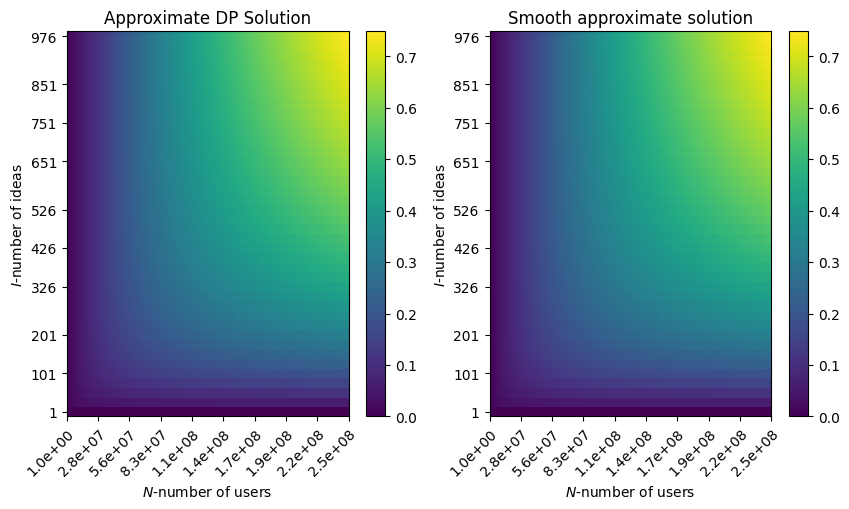

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

heatmap = ax1.pcolor(dp_res)
#heatmap = ax.pcolor(analytical_vals)
ax1.set_xticks(np.arange(dp_res.shape[1]) + 0.5, minor=False)
ax1.set_yticks(np.arange(dp_res.shape[0]) + 0.5, minor=False)

# Select a subset of the range for labeling to avoid crowding
num_x_labels = 10
num_y_labels = 10
x_indices = np.linspace(0, len(N_range) - 1, num=num_x_labels, dtype=int)
y_indices = np.linspace(0, len(I_range) - 1, num=num_y_labels, dtype=int)

ax1.set_xticks(x_indices + 0.5, minor=False)
ax1.set_yticks(y_indices + 0.5, minor=False)

ax1.set_xticklabels([f'{N_range[i]:.1e}' for i in x_indices], rotation=90)
ax1.set_yticklabels([I_range[i] for i in y_indices])

# Angle the x-axis tick labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax1.set_title("Approximate DP Solution")
ax1.set_xlabel("$N$-number of users")
ax1.set_ylabel("$I$-number of ideas")
plt.colorbar(heatmap)

################# Other plot
heatmap = ax2.pcolor(analytical_vals)

ax2.set_xticks(np.arange(dp_res.shape[1]) + 0.5, minor=False)
ax2.set_yticks(np.arange(dp_res.shape[0]) + 0.5, minor=False)

# Select a subset of the range for labeling to avoid crowding
num_x_labels = 10
num_y_labels = 10
x_indices = np.linspace(0, len(N_range) - 1, num=num_x_labels, dtype=int)
y_indices = np.linspace(0, len(I_range) - 1, num=num_y_labels, dtype=int)

ax2.set_xticks(x_indices + 0.5, minor=False)
ax2.set_yticks(y_indices + 0.5, minor=False)

ax2.set_xticklabels([f'{N_range[i]:.1e}' for i in x_indices], rotation=90)
ax2.set_yticklabels([I_range[i] for i in y_indices])

# Angle the x-axis tick labels
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax2.set_title("Smooth approximate solution")
ax2.set_xlabel("$N$-number of users")
ax2.set_ylabel("$I$-number of ideas")
plt.colorbar(heatmap)

## Metaproduction Function

### Increasing number of people & Number of Ideas

In [107]:
# Third subplot
#opt_vals = dp_res
opt_vals = np.load(f"../../data/{program}_metaproduction_array_N_step{N_step}_I_step{I_step}.npy")
#opt_vals = analytical_vals

# First subplot
n_idx = np.searchsorted(N_range, 249e6)
i_idx = np.searchsorted(I_range, 50)

opt_vals_N = opt_vals[i_idx,:]

# Second subplot
opt_vals_I = opt_vals[:,n_idx]




In [108]:
opt_vals.shape

(40, 25000)

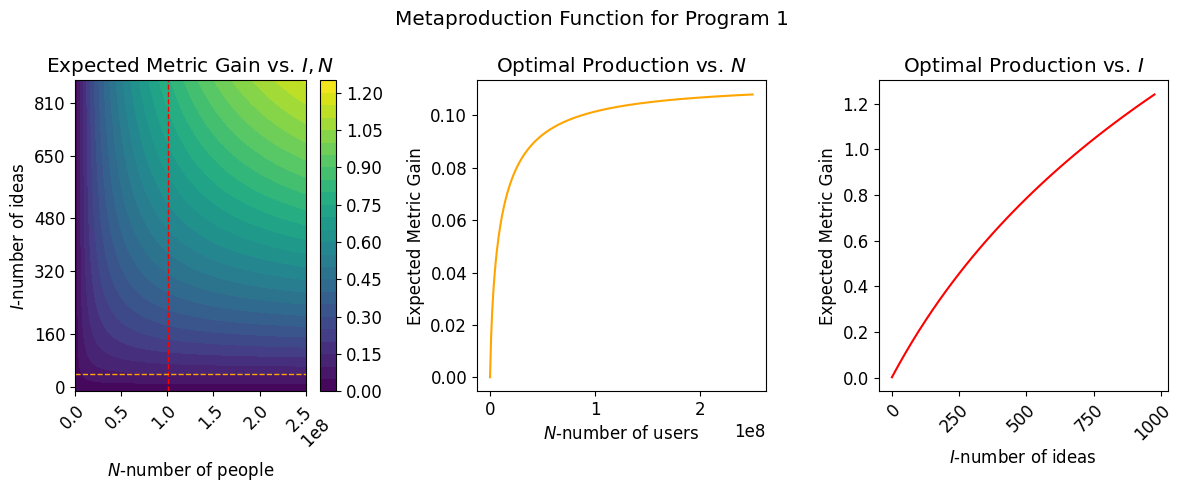

In [109]:
from scipy.ndimage import zoom


plt.rcParams['font.size'] = 12
# Create figure and subplots
fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(12,5))

# Plot the first subplot
ax1.plot(N_range, opt_vals_N, color = 'orange')
ax1.set_title("Optimal Production vs. $N$")
ax1.set_xlabel("$N$-number of users")
ax1.set_ylabel("Expected Metric Gain")

# Plot the second subplot
ax2.plot(I_range, opt_vals_I, color = 'red')
ax2.set_title("Optimal Production vs. $I$")
ax2.set_xlabel("$I$-number of ideas")
ax2.set_ylabel("Expected Metric Gain")

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Downscale the opt_vals matrix
downscale_factor = 0.01  # Adjust this factor to control downscaling
opt_vals_downscaled = zoom(opt_vals, (1, downscale_factor))

# Create new I_range and N_range for the downscaled matrix
I_range_downscaled = np.linspace(0, I_range[-1], opt_vals_downscaled.shape[0])
N_range_downscaled = np.linspace(0, N_range[-1], opt_vals_downscaled.shape[1])

# Plot the downscaled heatmap
heatmap = ax3.contourf(opt_vals_downscaled, cmap='viridis', levels = 30)

# Overlay the lines (adjusted for downscaled indices)
N_index = np.searchsorted(N_range_downscaled, 100e6)
I_index = np.searchsorted(I_range_downscaled, 50)

ax3.axvline(x=N_index, color='red', linestyle='--', linewidth=1)
ax3.axhline(y=I_index, color='orange', linestyle='--', linewidth=1)

# Set the ticks at the center of each cell
ax3.set_xticks(np.arange(opt_vals_downscaled.shape[1]) + 0.5, minor=False)
ax3.set_yticks(np.arange(opt_vals_downscaled.shape[0]) + 0.5, minor=False)

# Select a subset of the range for labeling to avoid crowding
num_x_labels = 6
num_y_labels = 7
x_indices = np.linspace(0, len(N_range_downscaled) - 1, num=num_x_labels, dtype=int)
ax3.set_xticks(x_indices + 0.5, minor=False)

# Set x-tick labels with scientific notation for the rightmost tick
x_labels = [f'{N_range_downscaled[i]/1e8:.1f} \n 1e8' if i == x_indices[-1] else f'{N_range_downscaled[i]/1e8:.1f}' for i in x_indices]
ax3.set_xticklabels(x_labels, rotation=90)


y_indices = np.linspace(0, len(I_range_downscaled) - 1, num=num_y_labels, dtype=int)
y_labels = np.linspace(I_range_downscaled[0], I_range_downscaled[-1], num=num_y_labels)
ax3.set_yticks(y_indices + 0.5, minor=False)
ax3.set_yticklabels([f'{10*int(y/10)}' for y in y_labels])



ax3.set_title("Expected Metric Gain vs. $I,N$")
ax3.set_xlabel("$N$-number of people")
ax3.set_ylabel("$I$-number of ideas")

ax3.set_ylim(0,35)

# Angle the x-axis tick labels
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
plt.colorbar(heatmap)

# title
#plt.suptitle(f"Metaproduction Function for {names[program]}")
plt.suptitle(f"Metaproduction Function for Program 1")

# Ensure tight layout for better spacing
plt.tight_layout()

# Save the figure to a PDF file with lower DPI to further reduce file size
fig.savefig(f'../../figures/{names[program]}_metaprod_fcn.png', dpi=100)

# Optionally, display the plot
plt.show()

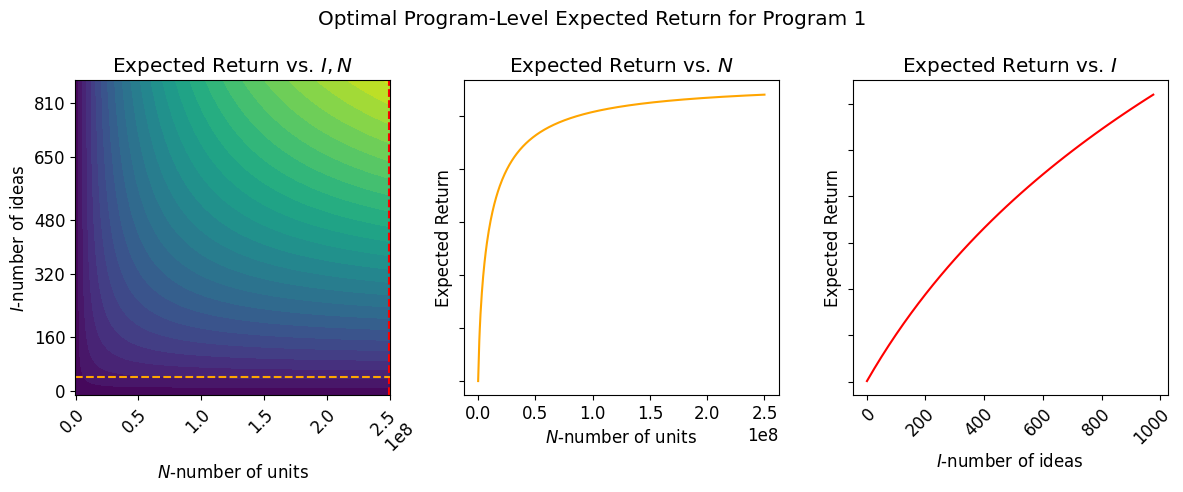

In [113]:
fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(12,5))

# Plot the first subplot
ax1.plot(N_range, opt_vals_N, color = 'orange')
ax1.set_title("Expected Return vs. $N$")
ax1.set_xlabel("$N$-number of units")
ax1.set_ylabel("Expected Return")
ax1.tick_params(axis='y', labelleft=False)  # Remove y labels

# Plot the second subplot
ax2.plot(I_range, opt_vals_I, color = 'red')
ax2.set_title("Expected Return vs. $I$")
ax2.set_xlabel("$I$-number of ideas")
ax2.set_ylabel("Expected Return")
ax2.tick_params(axis='y', labelleft=False)  # Remove y labels

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Downscale the opt_vals matrix
downscale_factor = 0.01  # Adjust this factor to control downscaling
opt_vals_downscaled = zoom(opt_vals, (1, downscale_factor))

# Create new I_range and N_range for the downscaled matrix
I_range_downscaled = np.linspace(0, I_range[-1], opt_vals_downscaled.shape[0])
N_range_downscaled = np.linspace(0, N_range[-1], opt_vals_downscaled.shape[1])

# Plot the downscaled heatmap
heatmap = ax3.contourf(opt_vals_downscaled, cmap='viridis', levels=30)

# Overlay the lines (adjusted for downscaled indices)
N_index = np.searchsorted(N_range_downscaled, 249e6)
I_index = np.searchsorted(I_range_downscaled, 50)

ax3.axvline(x=N_index, color='red', linestyle='--', linewidth=1.5)
ax3.axhline(y=I_index, color='orange', linestyle='--', linewidth=1.5)

# Set the ticks at the center of each cell
ax3.set_xticks(np.arange(opt_vals_downscaled.shape[1]) + 0.5, minor=False)
ax3.set_yticks(np.arange(opt_vals_downscaled.shape[0]) + 0.5, minor=False)

# Select a subset of the range for labeling to avoid crowding
num_x_labels = 6
num_y_labels = 7
x_indices = np.linspace(0, len(N_range_downscaled) - 1, num=num_x_labels, dtype=int)
ax3.set_xticks(x_indices + 0.5, minor=False)

# Set x-tick labels with scientific notation for the rightmost tick
x_labels = [f'{N_range_downscaled[i]/1e8:.1f} \n 1e8' if i == x_indices[-1] else f'{N_range_downscaled[i]/1e8:.1f}' for i in x_indices]
ax3.set_xticklabels(x_labels, rotation=90)

y_indices = np.linspace(0, len(I_range_downscaled) - 1, num=num_y_labels, dtype=int)
y_labels = np.linspace(I_range_downscaled[0], I_range_downscaled[-1], num=num_y_labels)
ax3.set_yticks(y_indices + 0.5, minor=False)
ax3.set_yticklabels([f'{10*int(y/10)}' for y in y_labels])

ax3.set_title("Expected Return vs. $I,N$")
ax3.set_xlabel("$N$-number of units")
ax3.set_ylabel("$I$-number of ideas")

ax3.set_ylim(0,35)

# Angle the x-axis tick labels
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Remove colorbar
# plt.colorbar(heatmap)

# title
plt.suptitle(f"Optimal Program-Level Expected Return for Program 1")

# Ensure tight layout for better spacing
plt.tight_layout()

# Save the figure to a PDF file with lower DPI to further reduce file size
fig.savefig(f'../../figures/{names[program]}_metaprod_fcn_external.pdf', dpi=100)

# Optionally, display the plot
plt.show()

In [111]:
marginal_product = np.diff(opt_vals_I)/25
marginal_product * 6e8

array([1297178.20405938, 1240836.57118881, 1189248.66450364,
       1141842.81781774, 1098134.64465849, 1057714.00931035,
       1020211.3266722 ,  985353.9453956 ,  952832.20123286,
        922448.38188713,  893989.78678251,  867272.24144842,
        842147.5368372 ,  818568.55946827,  796110.85724846,
        775105.61080128,  754937.47939935,  736167.15701287,
        718046.49345488,  700979.92719828,  684663.91341445,
        669270.24177617,  654296.05504894,  640016.21462148,
        626789.77423794,  613636.29471693,  601383.59507977,
        588943.84436273,  578020.06998469,  567211.72441019,
        556578.2702978 ,  546190.31942246,  536131.78554237,
        526502.51308202,  517421.50453581,  509030.90656501,
        501500.96479416,  491933.53142711,  483445.70850727])